In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import log
import seaborn as sb
from sklearn import metrics as metrics
import os

In [3]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

In [4]:
# create the taxonomy input for karp
taxatree = pd.read_csv('/mnt/scratch2/cedar/indices/i100_kraken_Dec6/taxonomy/nodes.dmp', sep='|', header=None)
out = open('/mnt/scratch2/cedar/indices/i100_kraken_Dec6/taxonomy/lineage.dmp', 'w')
for i, row in taxatree.iterrows():
    try:
        curtaxa = row[0]
        rmap = ncbi.get_rank([curtaxa])
        if curtaxa in rmap:
            if curtaxa != 1 and \
            ( \
            rmap[curtaxa] == 'species' or \
            rmap[curtaxa] == 'subspecies' or \
            rmap[curtaxa] == 'no rank' \
            ):
                lineage = ncbi.get_lineage(curtaxa)
            
                names = ncbi.get_taxid_translator(lineage)
                strr = ""
                for taxid in lineage:
                    strr += names[taxid] + ";"
                out.write(str(curtaxa) + "\t" + strr+"\n")
        else:
            out.write(str(curtaxa) + "\t" + "root;no rank\n")
    except ValueError:
        out.write(str(curtaxa) + "\t" + "root;no rank\n")
        print(curtaxa)
    #break
out.close()


In [11]:
lineage=pd.read_csv('/mnt/scratch2/cedar/indices/i100_kraken_Dec6/taxonomy/lineage.dmp', sep='\t', header=None)
lineage.columns = ['taxid', 'lineage']
seq2id=pd.read_csv('/mnt/scratch2/cedar/indices/i100_kraken_Dec6/seqid2taxid.map', sep='\t', header=None)
seq2id.columns = ['seqid', 'taxid']
out = pd.merge(seq2id, lineage, on = 'taxid', how='left')
out[['seqid', 'lineage']].to_csv('/mnt/scratch2/cedar/indices/i100_kraken_Dec6/seqid2lineage.map', sep='\t', index=None, header=None)


In [186]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.
    The relative difference is defined as
    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (|x_i + y_i|) otherwise
    This function returns two values.
    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.
    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 2.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd.fillna(0), nonZero

def L1(c1, c2, DF, cutoff=0.01, verbose=False):
    rd = pd.DataFrame(data = {"Name" : DF.index, "absDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    allRD = abs(DF[c1] - DF[c2])
    assert(len(rd.loc[nonZero]["absDiff"]) == len(allRD[nonZero]))
    rd["absDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["absDiff"][bothZero] = 0.0
    return rd.fillna(0), nonZero

In [5]:
# around 40,000 taxids are duplicates!!!!
partyp = {}
repeated_ids = []
with open('/mnt/scratch2/cedar/input_files/nodes.dmp') as f:
    for line in f:
        sp = line.split("|")
        if int(sp[0].strip()) in partyp:
            repeated_ids += [int(sp[0].strip())]
        else:
            partyp[int(sp[0].strip())] = [int(sp[1].strip()), sp[2].strip()]
taxaTree = pd.DataFrame.from_dict(partyp, orient='index', columns=['parent_id', 'level'])
taxaTree=taxaTree.reset_index()
taxaTree.columns = ['tax_id','parent_id', 'level']

In [520]:
def aggregate(df, taxidID, cntID, level = 'species'):
    agg = {}
    notFoundCntr = 0
    notFoundMap = {}
    print('num rows: {}'.format(len(df)))
    for idx, row in df.iterrows():
        taxid = row[taxidID] # should be of type int (number)
        cnt = row[cntID]
        if taxid in partyp:
            taxlevel = partyp[taxid][1]
#             print('next:{}'.format(taxlevel))
            while taxlevel != level and taxid != 1:
#                 print('{}:{}'.format(taxid, taxlevel))
                if taxid in partyp:    
                    taxid = partyp[taxid][0]
                    taxlevel = partyp[taxid][1]
                else:
                    if taxid not in notFoundMap:
                        notFoundMap[taxid] = 0
                        notFoundMap[taxid] += 1
#                     print('{} in loop'.format(taxid))
                    notFoundCntr+=1
                    break
            if taxlevel == level:
                if taxid not in agg:
                     agg[taxid] = 0
                agg[taxid] += cnt
        else:
            if taxid not in notFoundMap:
                notFoundMap[taxid] = 0
            notFoundMap[taxid] += 1
            notFoundCntr+=1
    print('notFound: {}'.format(notFoundCntr))
    agg_df = pd.DataFrame.from_dict(agg, orient='index').reset_index()
    agg_df.columns = ['taxid', 'count']
    for k, v in notFoundMap.items():
        print('{}:{}'.format(k, v))
    return agg_df

In [576]:
## Prepare the file with the accepted taxonomy format for Karp
seq2taxa = pd.read_table('/mnt/scratch5/cedar/indices/bacteria_i100_cami_kraken_k31_Jan22/seqid2taxid.map', header=None, names=['ref', 'taxid'])
lineagef = pd.read_table('/mnt/scratch5/cedar/indices/bacteria_i100_cami_kraken_k31_Jan22/taxonomy/lineage.dmp', header=None, names = ['taxid', 'lin'])
karptaxonomyf = pd.merge(seq2taxa, lineagef, on='taxid', how='left')
karptaxonomyf[['ref', 'lin']]. \
to_csv('/mnt/scratch5/cedar/indices/bacteria_i100_cami_kraken_k31_Jan22/seqid2lineage.map', \
       sep='\t', index=None, header=None)

## i100 dataset

In [600]:
##### i100 dataset #####
seq2taxid=pd.read_table('/mnt/scratch2/cedar/input_files/seqid2taxid.map', header=None, names=['ref', 'taxid'])
seq2taxid['acc'] = seq2taxid['ref'].str.split('|').str[0]
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_ref.truth')
truth_taxid = pd.merge(truth, seq2taxid, left_on='id', right_on='acc', how='left')
puff=pd.read_table('/mnt/scratch2/cedar/results/puff/aligned_trimmed_i100_31_sr1.quant/quant.sf')
sal=pd.read_table('/mnt/scratch2/cedar/results/salmon/aligned_trimmed_i100_31_sr1.salmon/quant.sf')
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/aligned_trimmed_i100_31_sr1_2.cedar')
# cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/i100_31_mohsen_align_newPuffer_trimmed_itThresholding_setCover2_segmentSize100_sr0.65.cedar')
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/trimmed_i100_k31_bracken.kreport', header=None)

## i100 over the complete database of bacteria, i100, and 4 cami toy datasets

In [685]:
seq2taxid=pd.read_table('/mnt/scratch5/cedar/indices/bacteria_i100_cami_kraken_k31_Jan22/seqid2taxid.map', \
                        header=None, names=['ref', 'taxid'])
for idx, row in seq2taxid.iterrows():
    if row['ref'].split('|')[0] == "kraken:taxid":
        seq2taxid.loc[idx, 'acc'] = row['ref'].split('|')[2].split('.')[0]
    else:
        seq2taxid.loc[idx, 'acc'] = row['ref'].split('|')[0].split('.')[0]

truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_ref.truth')
truth_taxid = pd.merge(truth, seq2taxid, left_on='id', right_on='acc', how='left')
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/i100_trimmed_BacteriaI100CAMI_top200_sr0.65_sparse_2.cedar')
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_trimmed_BacteriaI100CAMI_p16_sr0.65_bracken.kreport', header=None)

## Cami medium toy dataset

In [434]:
## Run once to generate the right format for the rest of analysis
## generate the truth for cami
readmappings= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M2_S001__insert_180_gs_read_mapping.tsv')
readmappings['number_reads'] = 1
truth_taxid = (readmappings[['tax_id', 'number_reads']].groupby('tax_id').sum().reset_index())
truth_taxid.columns = ['taxid', 'cnt']
truth_taxid.to_csv('/mnt/scratch2/cedar/results/cedar/truth_M2S1.map', sep='\t', index=None)

## generate seq2taxid file for cami
fullseq2taxidmap= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M2_S001__insert_180_gsa_mapping.tsv')
seq2taxid=fullseq2taxidmap[['#anonymous_gsa_id', 'tax_id']]
seq2taxid.columns = ['ref', 'taxid']
seq2taxid.to_csv('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/seqid2taxid_M2_S001__insert_180.map')


In [450]:
## generate seq2taxid file for cami kraken_format ids
refnames = pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M1S2_krak_refnames.lst', header=None)
uniqrefnames = np.unique(refnames)
outf = open('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/seqid2taxid_M1S2_krak.map', 'w')
for u in uniqrefnames:
    outf.write('{}\t{}\n'.format(u[1:], u[1:].split('|')[2]))
outf.close()

In [494]:
##### cami1 medium toy dataset #####
seq2taxid = pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/seqid2taxid_M2S1_krak.map', header=None)
seq2taxid.columns = ['ref', 'taxid']
truth_taxid= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/truth_M2S1.map')
# puff=pd.read_table('/mnt/scratch2/cedar/results/puff/cami_aligned_31_sr1.quant/quant.sf')
# sal=pd.read_table('/mnt/scratch2/cedar/results/salmon/cami_aligned_31_sr1.salmon/quant.sf')
# cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/cami_aligned_31_sr1_2.cedar')
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/cami_M2S1_31_sr1_0.cedar')
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/cami_M2S1_31_sr1_bracken.kreport', header=None)

## Cami M1S1 over complete dataset of bacteria, i100, and 4 cami toy datasets

In [696]:
# M1S1 full database
seq2taxid=pd.read_table('/mnt/scratch5/cedar/indices/bacteria_i100_cami_kraken_k31_Jan22/seqid2taxid.map', \
                        header=None, names=['ref', 'taxid'])
truth_taxid= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/truth_M1S1.map')
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/cami_S1M1_BacteriaI100CAMI_top200_sr0.65_2.cedar')
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/cami_S1M1_BacteriaI100CAMI_top200_sr0.65_bracken.kreport', header=None)
karp=pd.read_table('/mnt/scratch2/cedar/results/karp/M1S1_fullbacteriamash.freqs')
for idx, row in karp.iterrows():
    a = row['Label'].split('|')
    if a[0] == "kraken:taxid":
        karp.loc[idx, 'taxid'] = int(a[1])
    else:
        karp.loc[idx, 'taxid'] = int(a[2])

In [515]:
partyp[1042156]

[1485, 'species']

In [684]:
bracken[bracken['level'] == 'S']['count'].sum()

1857237

## Ditasic

In [686]:
ditasic = pd.read_table('/mnt/scratch2/cedar/results/ditasic/M2S1_bothends.res')
file2ref = []
parentDir = '/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/ditasic_M2_S001__insert_180_gsa_anonymous/'
for i, r in ditasic.iterrows():
    with open(os.path.join(parentDir, r['taxa.name'])) as f:
        ref = f.readline()
        ref = ref.strip()[1:]
        taxid = int(ref.split('|')[2])
#         print('{}, {}, {}'.format(os.path.join(parentDir, r['taxa.name']), ref, taxid))
        ditasic.loc[i,'ref'] = ref
        ditasic.loc[i,'taxid'] = taxid
        ditasic.loc[i, 'count'] = r['count.estimate']/2
#/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes

# continue for any dataset from here

In [697]:
bracken.columns = ['percentage', 'count', 'distinctCount', 'level', 'taxid', 'taxname']
bracken = bracken[bracken['level'] == 'S'][['taxid', 'taxname', 'count']]
bracken['taxname'] = bracken['taxname'].str.strip()

In [406]:
puff_taxid = pd.merge(puff, seq2taxid, left_on='Name', right_on='ref', how='left')
sal_taxid = pd.merge(sal, seq2taxid, left_on='Name', right_on='ref', how='left')

In [698]:
print('true cnt: {}'.format(truth_taxid['cnt'].sum()))
# print('pufferfish cnt: {}'.format(puff['NumReads'].sum()))
# print('salmon cnt: {}'.format(sal['NumReads'].sum()))
print('cedar cnt: {}'.format(cedar['count'].sum()))
print('bracken cnt: {}'.format(bracken['count'].sum()))
print('karp cnt: {}'.format(karp['ExpectedCounts'].sum()))

true cnt: 3719013
cedar cnt: 3663490.6126899994
bracken cnt: 3714608
karp cnt: 3263.97


In [699]:
truth_agg = aggregate(truth_taxid, 'taxid', 'cnt')
# sal_agg = aggregate(sal_taxid, 'taxid', 'NumReads')
# puff_agg = aggregate(puff_taxid, 'taxid', 'NumReads')
cedar_agg = aggregate(cedar, 'taxaId', 'count')
karp_agg = aggregate(karp, 'taxid', 'ExpectedCounts')

num rows: 225
notFound: 2
1240726:1
1240783:1
num rows: 710
notFound: 39
2500132:1
2015795:1
2496836:1
2203895:1
2005388:1
2364787:1
2320867:1
2488567:1
2220096:1
2036206:1
2259340:1
2203210:1
2109688:1
2109691:1
2109690:1
2500543:1
2203204:1
2306583:1
2382163:1
2495589:1
2126069:1
2493678:1
2493671:1
2493673:1
2493672:1
2493675:1
2493674:1
2493677:1
2109687:1
2500532:1
2493681:1
2493669:1
2493668:1
2282309:1
2282310:1
2093856:1
2341112:1
2219057:1
2218628:1
num rows: 174
notFound: 0


In [700]:
tru = pd.merge(truth_agg, cedar_agg, on = 'taxid', how='outer', suffixes=['', '_cedar']).fillna(0)
tru = pd.merge(tru, bracken, on = 'taxid', how='outer', suffixes=['', '_brac']).fillna(0)
tru = pd.merge(tru, karp_agg, on = 'taxid', how='outer', suffixes=['', '_karp']).fillna(0)

In [706]:
# tru[['count', 'count_cedar', 'count_brac', 'count_ditasic']].sum().astype(np.uint64)
# tru[['count', 'count_cedar', 'count_brac']].sum().astype(np.uint64)
tru[['count', 'count_cedar', 'count_brac', 'count_karp']].sum().astype(np.uint64)

count          3719011
count_cedar    3662772
count_brac     3714608
count_karp        3263
dtype: uint64

In [717]:
tru[tru['count_cedar'] > 10].sort_values(by='brac_diff', ascending=False)

,taxid,count,count_cedar,taxname,count_brac,count_karp,cedar_diff,brac_diff
139,1209372,131973.0,134761.0000,Bacillus sp. WBUNB009,72046.0,112.050,2788.0000,59927.0
350,562,0.0,4670.2300,Escherichia coli,41211.0,31.465,4670.2300,41211.0
67,621,92910.0,67157.7000,Shigella boydii,52208.0,84.270,25752.3000,40702.0
192,1386080,100623.0,100404.0000,Bacillus sp. EGD-AK10,65218.0,104.700,219.0000,35405.0
253,1423,0.0,173.4390,Bacillus subtilis,32266.0,33.029,173.4390,32266.0
47,1428,27179.0,26623.1000,Bacillus thuringiensis,52897.0,42.392,555.9000,25718.0
46,1396,10545.0,8459.4500,Bacillus cereus,30104.0,63.598,2085.5500,19559.0
521,1392,0.0,40.3159,Bacillus anthracis,6516.0,6.996,40.3159,6516.0
134,1203566,26706.0,26627.7000,Corynebacterium sp. KPL1859,20622.0,26.520,78.3000,6084.0
220,640511,0.0,25.2066,Burkholderia sp. CCGE1002,5985.0,0.000,25.2066,5985.0


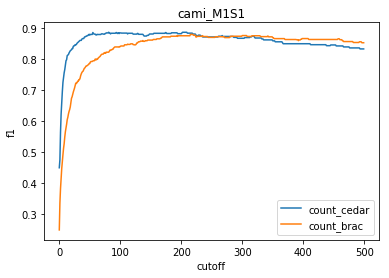

In [705]:
legends = ['count_cedar', 'count_brac']
for col in legends:
    precision = []
    recall = []    
    a = tru[(tru[col] > 0) | (tru['count'] != 0)]
    i = 0
    f1 = []
    n = 500
    for minCnt in range(0,n):
        tp = len(a[(a[col] > minCnt) & (a['count'] > 0)])
        fp = len(a[(a[col] > minCnt) & (a['count'] == 0)])
        fn = len(a[(a[col] <= minCnt) & (a['count'] > 0)])
        precision += [tp / (tp + fp)]
        recall += [tp / (tp + fn)]
        f1 += [2*(precision[i]*recall[i])/(precision[i]+recall[i])]
#         print('{}, {}, {}'.format(tp, fp, fn))
        i+=1
    #plt.plot(range(0, 100), recall)
    plt.plot(range(0, n), f1)
plt.legend(legends, loc='lower right')
plt.ylabel("f1")
plt.xlabel("cutoff")
plt.title("cami_M1S1")
plt.savefig('/mnt/scratch2/cedar/figs/camiM1S1_f1_{}.png'.format(n))

Text(0.5, 1.0, 'cami')

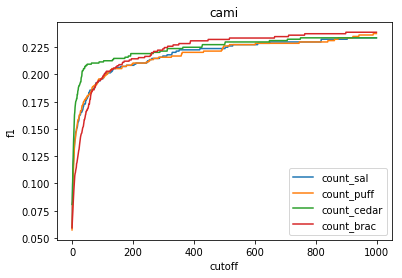

In [418]:
legends = ['count_sal', 'count_puff', 'count_cedar', 'count_brac']
for col in legends:
    precision = []
    recall = []    
    a = trusalpufcedbrac[(trusalpufcedbrac[col] > 0) | (trusalpufcedbrac['count'] != 0)]
    i = 0
    f1 = []
    n = 1000
    for minCnt in range(0,n):
        tp = len(a[(a[col] > minCnt) & (a['count'] > 0)])
        fp = len(a[(a[col] > minCnt) & (a['count'] == 0)])
        fn = len(a[(a[col] <= minCnt) & (a['count'] > 0)])
#         if col == 'count_cedar':
#             print('{},{},{}'.format(tp, fp, fn))
        precision += [tp / (tp + fp)]
        recall += [tp / (tp + fn)]
        f1 += [(precision[i]*recall[i])/(2*(precision[i]+recall[i]))]
        i+=1
    #plt.plot(range(0, 100), recall)
    plt.plot(range(0, n), f1)
plt.legend(legends, loc='lower right')
plt.ylabel("f1")
plt.xlabel("cutoff")
plt.title("cami")

In [704]:
minCnt = 100
res = []
for col in ['count_cedar', 'count_brac', 'count_karp']:
    #, 'count_karp']:
    df = tru[(tru[col] > minCnt) | (tru['count'] != 0)]
    df[df[col] <= minCnt][col] = 0
    rd, _ = relDiff('count', col, df, cutoff=minCnt)
    rd1, _ = L1('count', col, df, cutoff=minCnt) 
    res += [[
        col, len(df), df[col].sum(),
        df[['count', col]].corr(method='spearman')['count'][col],
        df[['count', col]].corr(method='pearson')['count'][col],
        metrics.explained_variance_score(df[col], df['count']),
        scipy.stats.kendalltau(df[col], df['count']).correlation,
        (0.5*rd['relDiff'].abs()).mean(),
        metrics.mean_absolute_error(df[col], df['count']),
        metrics.mean_squared_error(df[col], df['count']),
        metrics.mean_squared_log_error(df[col], df['count']),
        metrics.median_absolute_error(df[col], df['count']),
        rd1['absDiff'].sum(),
        metrics.mean_squared_error(df[col], df['count'])*len(df),
        scipy.spatial.distance.braycurtis(df[col], df['count']),
        scipy.spatial.distance.cosine(df[col], df['count']),
        scipy.spatial.distance.canberra(df[col], df['count'])
    ]]
final_metrics = pd.DataFrame.from_records(res, columns=['tool', '#rows', '#reads',
                                                       'sp', 'pr', 'explained_var', 'Kendalltau',
                                                        'MARD',  
                                                        'MAE', 'MSE', 'MSLE', 'MedAE', 'SAE', 'SSE',
                                                       'braycurtisDist', 'cosineDist', 'canberraDist'])
final_metrics = final_metrics.transpose()
final_metrics.columns = final_metrics.iloc[0]
final_metrics = final_metrics[1:]
final_metrics

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

tool,count_cedar,count_brac,count_karp
#rows,228,255,198
#reads,3.65928e+06,3.70475e+06,3142.01
sp,0.888793,0.861382,0.713806
pr,0.998372,0.985925,0.967784
explained_var,0.996712,0.970423,-996230
Kendalltau,0.809165,0.799062,0.600896
MARD,0.197494,0.253972,0.948762
MAE,578.68,1395.66,18767
MSE,5.52067e+06,4.26936e+07,2.22739e+09
MSLE,6.23148,9.36145,52.9841


In [348]:
a = np.load('/home/fatemeh/others_projects/ditasic/similarity_matrix.npy')

In [349]:
a

array([[249871.]])

In [328]:
trusalpufcedbrac[(trusalpufcedbrac['count_cedar'] > minCnt)]

,taxid,count,count_sal,count_puff,count_cedar,taxname,count_brac
0,562,1493685.0,1430201.159,1406064.613,1.430560e+06,Escherichia coli,1481960.0
1,727,120507.0,114640.865,116610.975,1.169680e+05,Haemophilus influenzae,116880.0
2,83558,79974.0,78213.465,78142.175,7.863590e+04,Chlamydia pneumoniae,79090.0
3,782,73307.0,71813.471,71767.715,7.216460e+04,Rickettsia prowazekii,71893.0
4,1423,272560.0,263965.741,265027.262,2.656240e+05,Bacillus subtilis,269266.0
5,134821,48374.0,47346.000,47274.007,4.757350e+04,Ureaplasma parvum,45798.0
6,86665,274294.0,262720.352,267824.339,2.690430e+05,Bacillus halodurans,271726.0
7,1358,414349.0,393029.611,402925.997,4.048260e+05,Lactococcus lactis,407743.0
8,518,466134.0,450130.078,455432.643,4.577070e+05,Bordetella bronchiseptica,458333.0
9,35554,248267.0,241612.939,242379.657,2.439730e+05,Geobacter sulfurreducens,246125.0


In [ ]:
for minCnt in range(0, 100):
    print(minCnt)

In [100]:
minCnt = 0
res = []
for col in ['count_sal', 'count_puff', 'count_cedar', 'count_brac']:
    df = trusalpufcedbrac[(trusalpufcedbrac[col] > minCnt) | (trusalpufcedbrac['count'] != 0)]
    df[df[col] <= minCnt][col] = 0
    rd, _ = relDiff('count', col, df, cutoff=minCnt)
    res += [[
        col, len(df), df[col].sum(),
        df[['count', col]].corr(method='spearman')['count'][col],
        metrics.explained_variance_score(df[col], df['count']),
        scipy.stats.kendalltau(df[col], df['count']).correlation,
        (0.5*rd['relDiff'].abs()).mean(),
        metrics.mean_absolute_error(df[col], df['count']),
        metrics.mean_squared_error(df[col], df['count']),
        metrics.mean_squared_log_error(df[col], df['count']),
        metrics.median_absolute_error(df[col], df['count']),
        scipy.spatial.distance.braycurtis(df[col], df['count']),
        scipy.spatial.distance.cosine(df[col], df['count']),
        scipy.spatial.distance.canberra(df[col], df['count'])
    ]]
final_metrics = pd.DataFrame.from_records(res, columns=['tool', '#rows', '#reads',
                                                       'sp', 'explained_var', 'Kendalltau',
                                                        'MARD',  
                                                        'MAE', 'MSE', 'MSLE', 'MedAE',
                                                       'braycurtisDist', 'cosineDist', 'canberraDist'])
final_metrics = final_metrics.transpose()
final_metrics.columns = final_metrics.iloc[0]
final_metrics = final_metrics[1:]
final_metrics

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


tool,count_sal,count_puff,count_cedar,count_brac
#rows,197,197,197,197
#reads,1.31571e+06,3.66231e+06,3.7131e+06,1.84504e+06
sp,0.983664,0.996942,0.998035,0.959301
explained_var,0.586569,0.998667,0.999509,0.00541485
Kendalltau,0.903421,0.983345,0.986739,0.946392
MARD,0.938505,0.0134296,0.0108701,0.352377
MAE,12173.1,421.531,164.905,9486.17
MSE,6.14174e+08,2.47306e+06,935798,5.61102e+08
MSLE,23.9163,0.0209179,0.0125635,2.0001
MedAE,4421,1,2.2,2280


In [515]:
final_metrics['count_cedar']

#rows                     272
#reads            2.60648e+07
sp                    0.82132
explained_var        0.998164
Kendalltau           0.725386
MARD                  0.69163
MAE                   3227.83
MSE               7.61004e+07
MSLE                  10.6949
MedAE                 57.4371
braycurtisDist      0.0166497
cosineDist        0.000246832
canberraDist          188.123
Name: count_cedar, dtype: object

In [300]:
kraken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_31.kraken', header=None)
kraken.columns = ['status', 'read', 'taxid', 'tmp', 'tmp2']
kraken = kraken[kraken['status'] == 'C'][['read', 'taxid']]
kraken['count'] = 1
kraken = kraken[['taxid', 'count']].groupby('taxid').sum().reset_index()
print(kraken['count'].sum())

247012


In [193]:
kraken_agg = aggregate(kraken, 'taxid', 'count')

notFound: 0


In [196]:
trukrak = pd.merge(truth_agg, kraken_agg, on = 'taxid', how='outer', suffixes=['', '_krak']).fillna(0)
col = 'count_krak'
print('{} ==> # of unique species: {}'.format(col, len(trukrak[trukrak[col] != 0])))
print('\tcorr: {}'.format(trukrak[(trukrak[col] != 0) | (trukrak['count'] != 0)]
                          [['count', col]].corr(method='spearman')['count'][col]))
rd, _ = relDiff('count', col, trukrak, cutoff=2)
print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

count_krak ==> # of unique species: 189
	corr: 0.9273881782943014
	MARD : 0.6429138449054718


In [286]:
col = 'count_cedar'
a = trusalpufcedbrac[(trusalpufcedbrac['count'] != 0) | (trusalpufcedbrac[col] > 0.001)][['taxid','count',col]]
a.sort_values(by='count', ascending=False, inplace=True)
a=a.reset_index()[['taxid','count', col]]

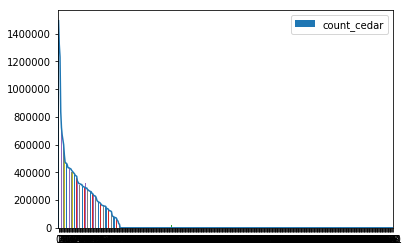

In [287]:
a.plot(kind='bar', y=col)
a['count'].plot()
plt.savefig('/mnt/scratch2/cedar/results/figs/i100_cedar_0.001.png')

In [234]:
trukrak['count_krak'].sum()

228964

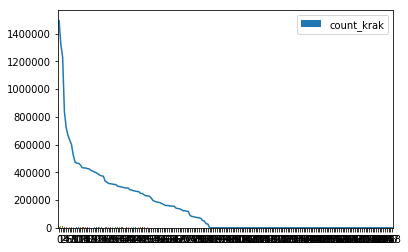

In [232]:
trukrak.sort_values(by='count', ascending=False, inplace=True)
b=trukrak.reset_index()[['taxid','count', 'count_krak']]
b.plot(kind='bar', y='count_krak')
b['count'].plot()

In [3]:
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_taxonomy.truth')
truth = truth.groupby('Species').sum().reset_index()
print(truth.head(1))
puff=pd.read_table('/mnt/scratch2/cedar/results/script_results/noalnmnt_i100_31_sr1_puff/out.tab')
puff = puff.groupby('Species').sum().reset_index()
print(puff.head(1))
salmon=pd.read_table('/mnt/scratch2/cedar/results/script_results/i100_31_sr1_salmon/out.tab')
salmon = salmon.groupby('Species').sum().reset_index()
print(salmon.head(1))
cedar=pd.read_table('/mnt/scratch2/cedar/results/script_results/i100_31_sr1_cedar/out.tab')
cedar = cedar.groupby('Species').sum().reset_index()
print(cedar.head(1))

                   Species    TaxID  NumCounts
0  Acinetobacter baumannii  1018343   262164.0
             Species   TaxID  NumCounts
0  Absiella dolichum  428127      1.274
             Species   TaxID  NumCounts
0  Absiella dolichum  428127      1.005
             Species  TaxID  NumCounts
0  Absiella dolichum  31971      662.0


In [152]:
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_31.kreport_bracken', header=None)
bracken.columns = ['percentage', 'aggrCount', 'NumCounts', 'level', 'taxid', 'taxname']
bracken.head(1)
bracken = bracken[bracken['level'] == 'S'][['taxid', 'taxname', 'NumCounts']]
bracken['taxname'] = bracken['taxname'].str.strip()
bracken.columns = ['taxid', 'taxname', 'count']

In [149]:
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_taxonomy.truth')
truth = truth.groupby('Species').sum().reset_index()


In [161]:
res = pd.merge(truth, bracken, left_on='Species', right_on='taxname', how='outer').fillna(0)

In [163]:
print('{} ==> # of unique species: {}'.format('bracken', len(res[res['Species'] != 0]['Species'].unique())))
print('\tcorr: {}'.format(res[['NumCounts', 'count']].corr(method='spearman')['NumCounts']['count']))
rd, _ = relDiff('NumCounts', 'count', res, cutoff=2)
print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

bracken ==> # of unique species: 85
	corr: 0.8808748841859805
	MARD : 0.6445672673488408


In [5]:
al=pd.merge(truth, puff, on='Species', how='outer')[['Species', 'NumCounts_x', 'NumCounts_y']].fillna(0)
al.columns = ['Species', 'truth', 'puff']
al=pd.merge(al, salmon, on='Species', how='outer')[['Species', 'truth', 'puff', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon']
al=pd.merge(al, cedar, on='Species', how='outer')[['Species', 'truth', 'puff', 'salmon', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon', 'cedar']
al=pd.merge(al, bracken, on='Species', how='outer')[['Species', 'truth', 'puff', 'salmon', 'cedar', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon', 'cedar', 'bracken']

In [252]:
#26667004
pd.set_option('display.width', 500)
al[['truth', 'puff', 'salmon', 'cedar', 'bracken']].sum().astype(np.uint64)

truth      26667004
puff       26206795
salmon     25893411
cedar      26336914
bracken      246970
dtype: uint64

In [7]:
print('number of distinct species:')
for col in ['puff', 'salmon', 'cedar', 'bracken']:
    print('{} ==> # of unique species: {}'.format(col, len(al[al[col] != 0]['Species'].unique())))
    print('\tcorr: {}'.format(al[al[col] != 0][['truth', col]].corr(method='spearman')['truth'][col]))
    rd, _ = relDiff('truth', col, al, cutoff=2)
    print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

number of distinct species:
puff ==> # of unique species: 673
	corr: 0.5771148730419895
	MARD : 0.44326697994503655
salmon ==> # of unique species: 485
	corr: 0.6627743789409638
	MARD : 0.3759827143824895
cedar ==> # of unique species: 750
	corr: 0.5363935842728118
	MARD : 0.9442527780267141
bracken ==> # of unique species: 188
	corr: 0.9220709392084507
	MARD : 0.16307294380330192


In [22]:
al[al['salmon'] != 0]

,Species,truth,puff,salmon,cedar,bracken
0,Acinetobacter baumannii,262164.0,59875.158,243181.077,938622.0,2395.0
1,Alkalilimnicola ehrlichii,230160.0,52339.024,224504.034,56202.0,2234.0
2,Alkaliphilus metalliredigens,374667.0,85591.446,352826.229,109518.0,3465.0
3,Bacillus anthracis,408054.0,61818.911,394338.602,311929.0,3684.0
4,Bacillus cereus,1320777.0,248185.262,1271628.751,823304.0,12241.0
5,Bacillus clausii,286614.0,64841.676,280708.654,78647.0,2651.0
6,Bacillus halodurans,274294.0,63007.950,263758.940,93128.0,2512.0
7,Bacillus subtilis,272560.0,62709.799,265348.603,84908.0,2543.0
8,Bacillus thuringiensis,372187.0,161021.430,356551.975,374846.0,3272.0
9,Bacteroides thetaiotaomicron,402214.0,89738.833,384015.731,94806.0,3641.0


In [8]:
print('number of distinct shared species with truth:')
for col in ['puff', 'salmon', 'cedar', 'bracken']:
    print('{}: {}'.format(col, len(al[(al['truth'] != 0) & (al[col] != 0)]['Species'].unique())))

number of distinct shared species with truth:
puff: 85
salmon: 85
cedar: 85
bracken: 0


In [4]:
pufmap=pd.read_csv('/home/mohsen/pufferfish-test/out', sep='\t', header=None)
pufmap.columns = ['origread', 'puf']
pufmap['read'] = pufmap['origread'].str.split(';').str[0].str.split('/').str[1]

In [ ]:
salmap=pd.read_csv('/mnt/scratch4/mohsen/puffalign_test/out', sep='\t', header=None)
salmap.columns = ['origread', 'sal']
salmap['read'] = salmap['origread'].str.split(';').str[0].str.split('/').str[1]

In [ ]:
print(len(salmap))
print(len(pufmap))

In [ ]:
salmap.head(1)

In [58]:
print('Puff average hits over read: {}'.format(pufmap.groupby('read')['puf'].count().mean()))
print('Puff average hits over read and ref: {}'.format(pufmap.groupby(['read', 'puf'])['puf'].count().mean()))
print('Sal average hits over read: {}'.format(salmap.groupby('read')['sal'].count().mean()))
print('Sal average hits over read and ref: {}'.format(salmap.groupby(['read', 'sal'])['sal'].count().mean()))

Puff average hits over read: 1535.147682745575
Puff average hits over read and ref: 169.01331248918123
Sal average hits over read: 1524.5548226218552
Sal average hits over read and ref: 168.46238910425558


In [74]:
pufmap['count'] = 1
puf_uniqreadref = (pufmap.groupby(['read', 'puf'])['count'].count()).reset_index()
salmap['count'] = 1
sal_uniqreadref = (salmap.groupby(['read', 'sal'])['count'].count()).reset_index()

In [75]:
merged = pd.merge(sal_uniqreadref, puf_uniqreadref, left_on=['read', 'sal'], right_on=['read', 'puf'], how = 'outer').fillna(0)

In [76]:
len(merged)

740800

In [91]:
pufbetter=merged[(merged['count_x'] == 0) & (merged['read'] == merged['puf'])]
salbetter=merged[(merged['count_y'] == 0) & (merged['read'] == merged['sal'])]
pufworse=merged[(merged['count_x'] == 0) & (merged['read'] != merged['puf'])]
salworse=merged[(merged['count_y'] == 0) & (merged['read'] != merged['sal'])]

In [95]:
print('# of references found by puf but not sal: {}'.format(len(pufbetter)))
print('# of references found by sal but not puf: {}'.format(len(salbetter)))
print('# of invalid references found by puf but not sal: {}'.format(len(pufworse)))
print('# of invalid references found by sal but not puf: {}'.format(len(salworse)))
print('sum of valid hits found by puf but not sal: {}'.format(pufbetter['count_y'].sum()))
print('sum of invalid hits found by puf but not sal: {}'.format(pufworse['count_y'].sum()))
print('sum of valid hits found by sal but not puf: {}'.format(salbetter['count_x'].sum()))
print('sum of invalid hits found by sal but not puf: {}'.format(salworse['count_x'].sum()))

# of references found by puf but not sal: 164
# of references found by sal but not puf: 0
# of invalid references found by puf but not sal: 3908
# of invalid references found by sal but not puf: 1344
sum of valid hits found by puf but not sal: 52565.0
sum of invalid hits found by puf but not sal: 265940.0
sum of valid hits found by sal but not puf: 0
sum of invalid hits found by sal but not puf: 3677.0
